In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

# Ford data

In [25]:
# Read the data
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

# Count the number of classes
num_classes = len(np.unique(y_train))
print("Number of classes: " + str(num_classes))

# Standardize the labels to positive integers. The expected labels will then be 0 and 1.
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Use 20% of training data for validation
train_set_size = int(len(x_train) * 0.8)
valid_set_size = len(x_train) - train_set_size
print("Training set size: " + str(train_set_size))
print("Validation set size: " + str(valid_set_size))

# split the x_train and y_train set into two
seed = torch.Generator().manual_seed(42)
x_train, x_valid = data.random_split(x_train, [train_set_size, valid_set_size], generator=seed)
y_train, y_valid = data.random_split(y_train, [train_set_size, valid_set_size], generator=seed)

# Convert to numpy arrays
x_train = x_train.dataset
x_valid = x_valid.dataset
y_train = y_train.dataset
y_valid = y_valid.dataset

Number of classes: 2
Training set size: 2880
Validation set size: 721


500
Class 0 explained variance: 0.9293035517000288


Class 1 explained variance: 0.9531240566691049


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


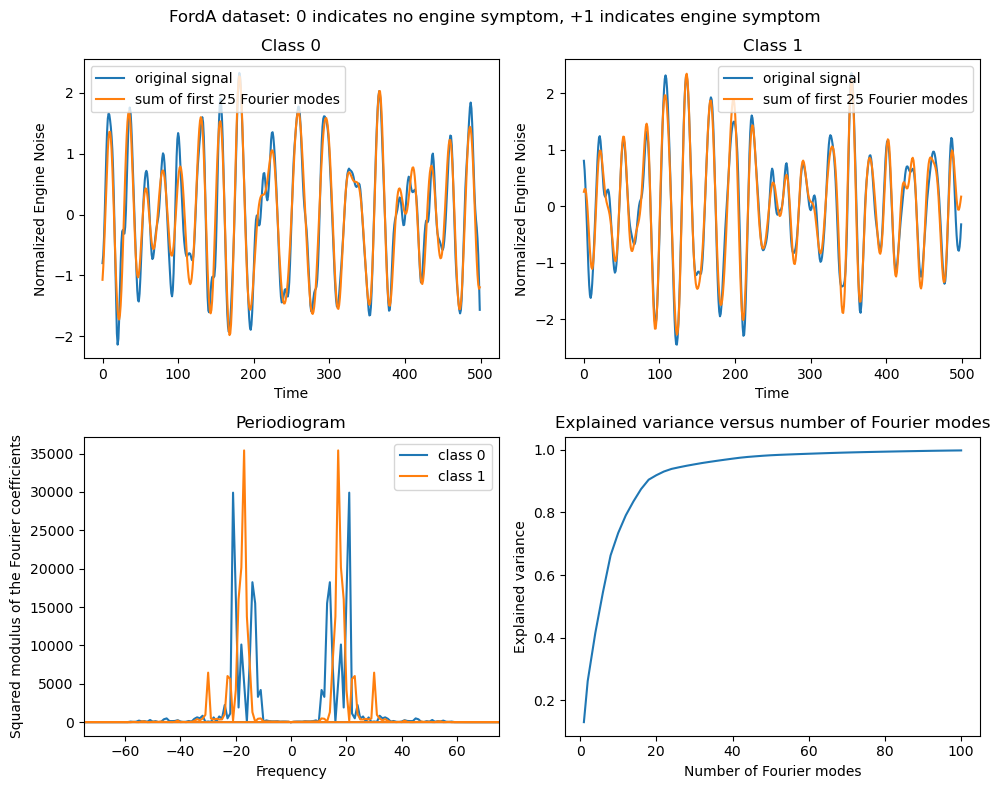

In [26]:
# Visualize the data and periodiogram in 1 figure
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
n = x_train.shape[1]
fourier_modes = 25

plt.figure(figsize=(10, 8))
plt.suptitle('FordA dataset: 0 indicates no engine symptom, 1 indicates engine symptom')

# Plot the original vs. the sum of the first most dominant fourier_modes 
# modes of the Fourier series for each class
for i, c in enumerate(classes, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, i-th plot
    c_x_train = x_train[y_train == c]
    fourier_series = np.fft.fft(c_x_train)[0]
    
    # Get the indices of the 4 largest Fourier coefficients
    fourier_modes_indices = np.abs(fourier_series).argsort()[-fourier_modes:]
    
    # Set all other coefficients to zero
    dominant_modes = np.zeros_like(fourier_series)
    dominant_modes[fourier_modes_indices] = fourier_series[fourier_modes_indices]
    
    # Perform an inverse Fourier transform
    inverse_transform = np.fft.ifft(dominant_modes)

    print("Class", c, "explained variance:", np.var(inverse_transform) / np.var(c_x_train))
    
    plt.plot(c_x_train[0], label="original signal")
    plt.plot(inverse_transform, label=f"sum of first {fourier_modes} Fourier modes")
    plt.legend(loc="best")
    plt.xlabel('Time')
    plt.ylabel('Normalized Engine Noise')
    plt.title(f'Class {c}')

# Plot the periodiogram
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third plot
for c in classes:
    c_x_train = x_train[y_train == c]
    periodiogram = np.abs(np.fft.fft(c_x_train)[0]) ** 2
    plt.plot(np.fft.fftfreq(n, 1 / n), periodiogram, label="class " + str(c))
plt.legend(loc="best")
plt.xlim(-75, 75)
plt.xlabel('Frequency')
plt.ylabel('Squared modulus of the Fourier coefficients')
plt.title('Periodiogram')

# Plot the explained variance versus fourier modes
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth plot
explained_variance = []
num_modes_range = range(1, 101)
for fourier_modes in num_modes_range:
    explained_variance.append(0)
    for c in classes:
        c_x_train = x_train[y_train == c]
        fourier_series = np.fft.fft(c_x_train)[0]
        fourier_modes_indices = np.abs(fourier_series).argsort()[-fourier_modes:]
        dominant_modes = np.zeros_like(fourier_series)
        dominant_modes[fourier_modes_indices] = fourier_series[fourier_modes_indices]
        inverse_transform = np.fft.ifft(dominant_modes)
        explained_variance[-1] += np.var(inverse_transform) / np.var(c_x_train)
    explained_variance[-1] /= len(classes)

plt.plot(num_modes_range, explained_variance)
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Explained variance versus number of Fourier modes')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Class 1')

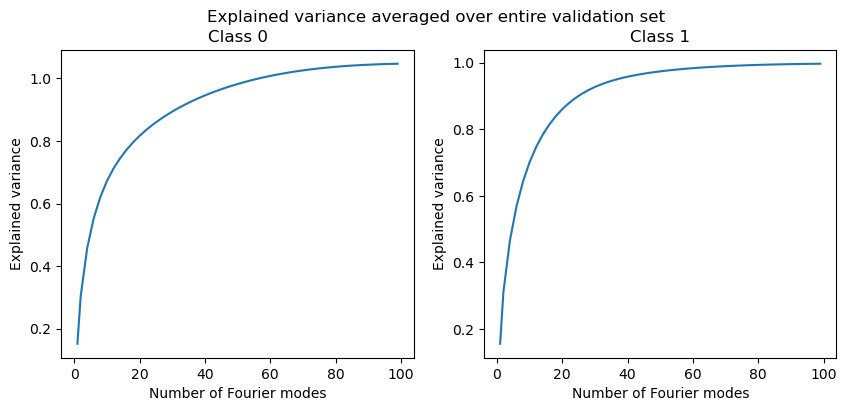

In [33]:
# Create a plot showing the explained variance for the first 50 fourier modes, averaged over the entire validation set
explained_variance_class_0 = []
explained_variance_class_1 = []
num_modes_range = range(1, 100)

for fourier_modes in num_modes_range:
    explained_variance_class_0.append(0)
    explained_variance_class_1.append(0)

    for c in classes:
        c_x_valid = x_valid[y_valid == c]
        for sample in c_x_valid:
            fourier_series = np.fft.fft(sample)
            fourier_modes_indices = np.abs(fourier_series).argsort()[-fourier_modes:]
            dominant_modes = np.zeros_like(fourier_series)
            dominant_modes[fourier_modes_indices] = fourier_series[fourier_modes_indices]
            inverse_transform = np.fft.ifft(dominant_modes)
            explained_variance = np.var(inverse_transform) / np.var(sample)
            if c == 0:
                explained_variance_class_0[-1] += explained_variance
            else:
                explained_variance_class_1[-1] += explained_variance

    explained_variance_class_0[-1] /= len(c_x_valid)
    explained_variance_class_1[-1] /= len(c_x_valid)

plt.figure(figsize=(10, 4))
plt.suptitle("Explained variance averaged over entire validation set")

plt.subplot(1, 2, 1)
plt.plot(num_modes_range, explained_variance_class_0, label="Class 0")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 0')

plt.subplot(1, 2, 2)
plt.plot(num_modes_range, explained_variance_class_1, label="Class 1")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 1')

# Kepler data

In [6]:
# Kepler Lightcurve dataset
directory = "../../kepler_lightcurve_data/"

# Load KeplerLightCurves.csv
data = np.genfromtxt(directory + "KeplerLightCurves.csv", delimiter=',')
X = data[:, :-1]
y = data[:, -1]

print("X shape: ", X.shape)

# Prepare labels
y = y - 1 # Shift the labels to start from 0
print("y shape and values: ", y.shape, np.unique(y))

X = np.array(X)
y = np.array(y)

X shape:  (1319, 4767)
y shape and values:  (1319,) [0. 1. 2. 3. 4. 5. 6.]


In [12]:
# Create a plot showing the explained variance for the first 50 fourier modes, averaged over the entire validation set
classes = range(0, 7, 1)
explained_variance_class_0 = []
explained_variance_class_1 = []
explained_variance_class_2 = []
explained_variance_class_3 = []
explained_variance_class_4 = []
explained_variance_class_5 = []
explained_variance_class_6 = []
num_modes_range = range(5, 2000, 5)

for modes in num_modes_range:
    explained_variance_class_0.append(0)
    explained_variance_class_1.append(0)
    explained_variance_class_2.append(0)
    explained_variance_class_3.append(0)
    explained_variance_class_4.append(0)
    explained_variance_class_5.append(0)
    explained_variance_class_6.append(0)

    for c in classes:
        c_x = X[y == c]
        for sample in c_x:
            fourier_series = np.fft.fft(sample)
            fourier_modes_indices = np.abs(fourier_series).argsort()[-modes:]
            dominant_modes = np.zeros_like(fourier_series)
            dominant_modes[fourier_modes_indices] = fourier_series[fourier_modes_indices]
            inverse_transform = np.fft.ifft(dominant_modes)
            explained_variance = np.var(inverse_transform) / np.var(sample)
            
            if c == 0: explained_variance_class_0[-1] += explained_variance
            elif c == 1: explained_variance_class_1[-1] += explained_variance
            elif c == 2: explained_variance_class_2[-1] += explained_variance
            elif c == 3: explained_variance_class_3[-1] += explained_variance
            elif c == 4: explained_variance_class_4[-1] += explained_variance
            elif c == 5: explained_variance_class_5[-1] += explained_variance
            elif c == 6: explained_variance_class_6[-1] += explained_variance

        if c == 0: explained_variance_class_0[-1] /= len(c_x)
        elif c == 1: explained_variance_class_1[-1] /= len(c_x)
        elif c == 2: explained_variance_class_2[-1] /= len(c_x)
        elif c == 3: explained_variance_class_3[-1] /= len(c_x)
        elif c == 4: explained_variance_class_4[-1] /= len(c_x)
        elif c == 5: explained_variance_class_5[-1] /= len(c_x)
        elif c == 6: explained_variance_class_6[-1] /= len(c_x)

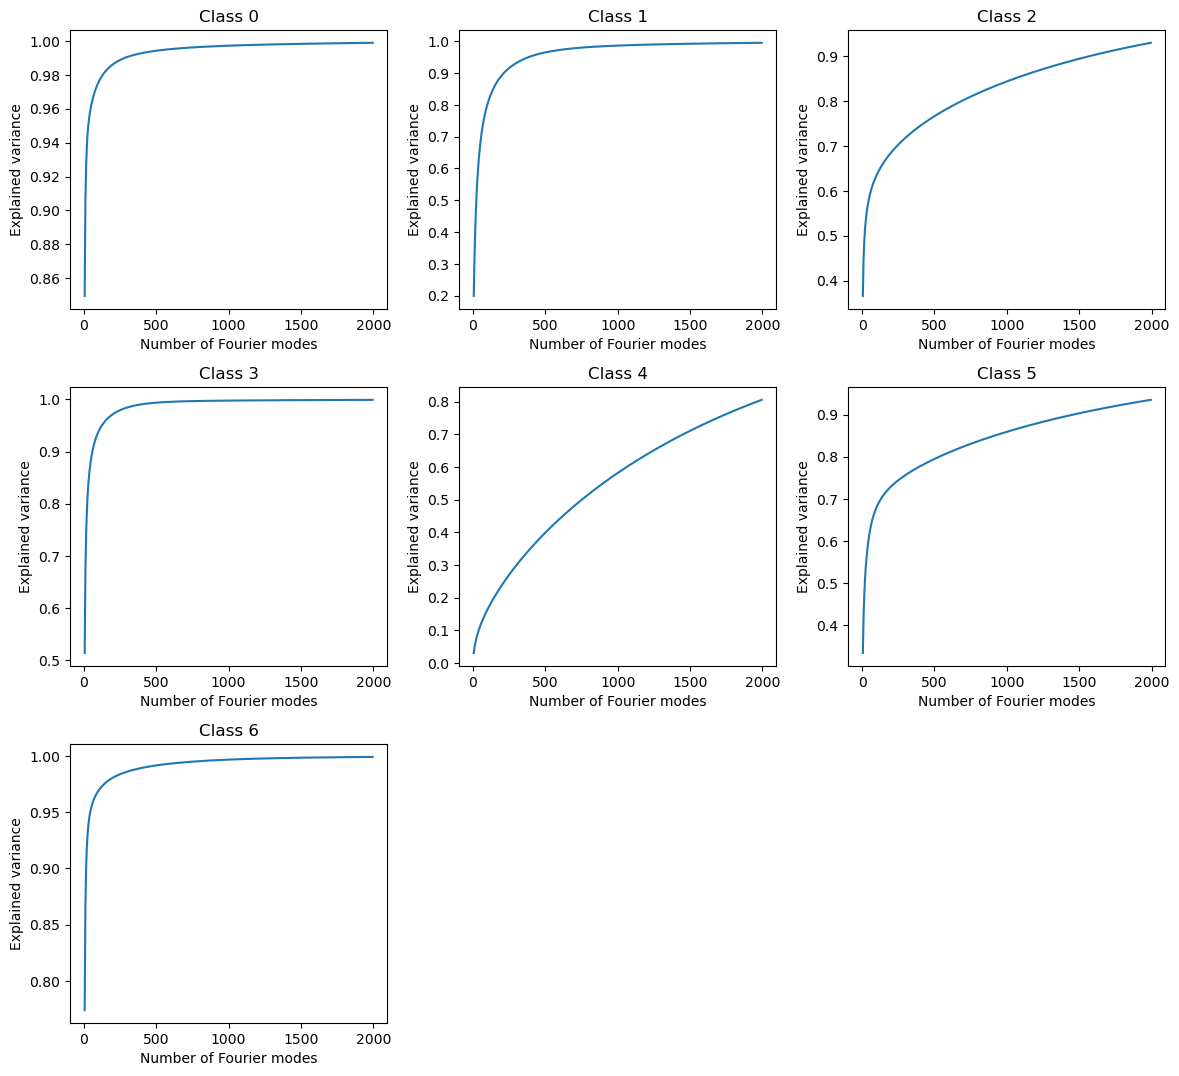

In [19]:
plt.figure(figsize=(12, 14))

plt.subplot(4, 3, 1)
plt.plot(num_modes_range, explained_variance_class_0, label="Class 0")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 0')

plt.subplot(4, 3, 2)
plt.plot(num_modes_range, explained_variance_class_1, label="Class 1")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 1')

plt.subplot(4, 3, 3)
plt.plot(num_modes_range, explained_variance_class_2, label="Class 2")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 2')

plt.subplot(4, 3, 4)
plt.plot(num_modes_range, explained_variance_class_3, label="Class 3")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 3')

plt.subplot(4, 3, 5)
plt.plot(num_modes_range, explained_variance_class_4, label="Class 4")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 4')

plt.subplot(4, 3, 6)
plt.plot(num_modes_range, explained_variance_class_5, label="Class 5")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 5')

plt.subplot(4, 3, 7)
plt.plot(num_modes_range, explained_variance_class_6, label="Class 6")
plt.xlabel('Number of Fourier modes')
plt.ylabel('Explained variance')
plt.title('Class 6')

plt.tight_layout()
plt.show()